### Problem List: 60, 61, 85

# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.22.4
tensorflow version = 2.6.0


In [2]:
import os
import cv2
import csv
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats

from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, concatenate, SimpleRNN, LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TerminateOnNaN, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l1, l1_l2
from tensorflow.keras import regularizers

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt

In [3]:
seed_value = 10 #original

# seed_value = 0 #[RandomSeed]
# seed_value = 20
# seed_value = 42 
# seed_value = 64
# seed_value = 100
# seed_value = 123
# seed_value = 200
# seed_value = 456
# seed_value = 1001
# seed_value = 12321

os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# GPU Setting

In [4]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Global Variables

In [6]:
KeypointsROOT = "../../2_EyeTrackingAnalysis/data/"
timeStamp_path = "../Facial Subtask/_timeStamp_0916.csv" ### [update] 2023/09/16
videoType_path = "../Facial Subtask/_videoType.csv"

n_FOLD = 5
n_FEATURE = 12
n_PERIOD = 300 
n_GAP = 150

isSeg = True  ### is Normalize by Segment or not

# remove_dementia_pid_list = [22, 33, 57, 58, 64, 66, 67]
# remove_dementia_pid_list_str = ['22', '33', '57', '58', '64', '66', '67']

In [7]:
# DATE = "20240620"
DATE = "20240821"


flag_MMSE = False
flag_MMSE_Scaled = False
flag_CDR = False
flag_CDR_Scaled = False
flag_CDRSOB = True
flag_CDRSOB_Scaled = False

flag_PreTrained = True

# Load Timestamp

In [8]:
timeStamp_dict = {}

def load_timestamp():
    if not os.path.exists(timeStamp_path):
        print(f'[Timestamp] CSV does not exit.')
    else:
        df = pd.read_csv(timeStamp_path)
        df = df.fillna(0)
        n_row, n_col = df.shape[0], df.shape[1]
        
        data_dict = {}
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            start1 = int(float(df.iloc[idx, 1]))
            end1 = int(float(df.iloc[idx, 2]))
            data_dict[pid] = {}
            data_dict[pid]["1-start"] = start1
            data_dict[pid]["1-end"] = end1
    return data_dict

timeStamp_dict = load_timestamp()

print(f'=== number of pid in timeStamp CSV file: {len(timeStamp_dict)} ===\n')
print(timeStamp_dict)

=== number of pid in timeStamp CSV file: 100 ===

{1: {'1-start': 67, '1-end': 119}, 2: {'1-start': 111, '1-end': 149}, 3: {'1-start': 62, '1-end': 96}, 4: {'1-start': 111, '1-end': 150}, 5: {'1-start': 119, '1-end': 168}, 6: {'1-start': 57, '1-end': 79}, 7: {'1-start': 62, '1-end': 84}, 8: {'1-start': 93, '1-end': 110}, 9: {'1-start': 61, '1-end': 75}, 10: {'1-start': 106, '1-end': 128}, 11: {'1-start': 145, '1-end': 160}, 12: {'1-start': 73, '1-end': 109}, 13: {'1-start': 71, '1-end': 193}, 14: {'1-start': 59, '1-end': 79}, 15: {'1-start': 66, '1-end': 108}, 16: {'1-start': 91, '1-end': 139}, 17: {'1-start': 85, '1-end': 137}, 18: {'1-start': 90, '1-end': 118}, 19: {'1-start': 84, '1-end': 148}, 20: {'1-start': 71, '1-end': 101}, 21: {'1-start': 64, '1-end': 95}, 22: {'1-start': 87, '1-end': 118}, 23: {'1-start': 82, '1-end': 118}, 24: {'1-start': 80, '1-end': 231}, 25: {'1-start': 71, '1-end': 99}, 26: {'1-start': 72, '1-end': 115}, 27: {'1-start': 67, '1-end': 107}, 28: {'1-start':

# Load Label

In [9]:
Label_dict = {}
excel_path = "../Label_Data_Info.xlsx" 

df_label = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', '_Label']) # [update] 2023/06/17
df_label = df_label.fillna(0)
df_label = df_label.astype({"_Label": int})

Label_arr = np.array(df_label['_Label'])
Label_dict = dict(zip(df_label.編號, df_label._Label))

def checkDataDistribution(KeypointsROOT):
    labelList = []
    for folder in list(os.listdir(KeypointsROOT)):
        # if folder not in remove_dementia_pid_list_str:
        if int(folder) in timeStamp_dict and folder!="60" and folder!="61" and folder!="85": 
            label = Label_dict[int(folder)]
            labelList.append(label)
    lableArray = np.array(labelList)
    print(f'Data we have ...')
    print(f'# of AD pid: {np.count_nonzero(lableArray == 1)}')
    print(f'# of NC pid: {np.count_nonzero(lableArray == 0)}')
    print(f'total number of pid: {np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)}\n')
    print(f'Ratio (all guess Positive): {round(np.count_nonzero(lableArray == 1)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    print(f'Ratio (all guess Negative): {round(np.count_nonzero(lableArray == 0)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    
    
checkDataDistribution(KeypointsROOT)

print(Label_dict)

Data we have ...
# of AD pid: 29
# of NC pid: 67
total number of pid: 96

Ratio (all guess Positive): 0.3021
Ratio (all guess Negative): 0.6979
{1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}


# Load MMSE/CDR/CDRSOB Score

In [10]:
excel_path = "../Score_Data_Info.xlsx"

df_MMSE = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'MMSE/總分30'])
df_MMSE = df_MMSE.fillna(0)
df_MMSE = df_MMSE.astype({"MMSE/總分30": int})
df_MMSE = df_MMSE.rename(columns={'MMSE/總分30': 'MMSE'})
MMSE_dict = dict(zip(df_MMSE.編號, df_MMSE.MMSE))

df_CDR = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'my_CDR'])
df_CDR = df_CDR.fillna(0)
df_CDR = df_CDR.astype({"my_CDR": float})
df_CDR = df_CDR.rename(columns={'my_CDR': 'CDR'})
CDR_dict = dict(zip(df_CDR.編號, df_CDR.CDR))

df_CDRSOB = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'my_CDRSOB'])
df_CDRSOB = df_CDRSOB.fillna(0)
df_CDRSOB = df_CDRSOB.astype({"my_CDRSOB": float})
df_CDRSOB = df_CDRSOB.rename(columns={'my_CDRSOB': 'CDRSOB'})
CDRSOB_dict = dict(zip(df_CDRSOB.編號, df_CDRSOB.CDRSOB))

print(CDRSOB_dict)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 1.5, 5: 1.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 6.0, 10: 1.0, 11: 9.0, 12: 1.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 3.0, 17: 1.0, 18: 1.5, 19: 2.5, 20: 3.0, 21: 0.0, 22: 0.0, 23: 6.0, 24: 1.5, 25: 3.0, 26: 1.0, 27: 4.0, 28: 0.5, 29: 0.0, 30: 0.0, 31: 1.0, 32: 2.0, 33: 8.0, 34: 0.0, 35: 2.5, 36: 8.0, 37: 1.5, 38: 0.5, 39: 2.0, 40: 1.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 1.5, 46: 0.0, 47: 0.0, 48: 2.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 5.0, 61: 1.5, 62: 4.0, 63: 2.5, 64: 5.0, 65: 1.0, 66: 4.5, 67: 0.5, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0}


# Normalize Score

In [11]:
MMSE_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_MMSE_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = MMSE_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

MMSE_dict_scaled = normalize_MMSE_score(MMSE_dict)

In [12]:
CDR_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_CDR_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = CDR_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

CDR_dict_scaled = normalize_CDR_score(CDR_dict)

In [13]:
CDRSOB_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_CDRSOB_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = CDRSOB_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

CDRSOB_dict_scaled = normalize_CDRSOB_score(CDRSOB_dict)
print(CDRSOB_dict_scaled)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.16666666666666666, 5: 0.1111111111111111, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.6666666666666666, 10: 0.1111111111111111, 11: 1.0, 12: 0.1111111111111111, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.3333333333333333, 17: 0.1111111111111111, 18: 0.16666666666666666, 19: 0.2777777777777778, 20: 0.3333333333333333, 21: 0.0, 22: 0.0, 23: 0.6666666666666666, 24: 0.16666666666666666, 25: 0.3333333333333333, 26: 0.1111111111111111, 27: 0.4444444444444444, 28: 0.05555555555555555, 29: 0.0, 30: 0.0, 31: 0.1111111111111111, 32: 0.2222222222222222, 33: 0.8888888888888888, 34: 0.0, 35: 0.2777777777777778, 36: 0.8888888888888888, 37: 0.16666666666666666, 38: 0.05555555555555555, 39: 0.2222222222222222, 40: 0.1111111111111111, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.16666666666666666, 46: 0.0, 47: 0.0, 48: 0.2222222222222222, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.1111111111111111, 58: 0.1111111111111111, 59: 0.1111111111111111, 60: 0.55555555555555

# Load Video Type
* source file: **_videoType.csv**
* This file is produced from python file: **pre_cutVideo.ipynb**

In [14]:
videoType_dict = {}

def load_videoType_from_CSV_file(fileName):
    tmp_dict = {}
    if not os.path.exists(fileName):
        print(f'[VideoType] CSV does not exit.')
    else:
        df = pd.read_csv(fileName)
        n_row, n_col = df.shape[0], df.shape[1]
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            videotype = int(df.iloc[idx, 1])
            tmp_dict[pid] = videotype
    return tmp_dict
    
videoType_dict = load_videoType_from_CSV_file(videoType_path)
print(videoType_dict)

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 100: 2, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 2, 83: 2, 84: 2, 85: 2, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2, 92: 2, 93: 2, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 99: 2}


# Load Subject ID

In [15]:
pid_dict = {}
allID_list = []

def load_id():
    data_dict = {}
    id_list = []
    
    for pid in list(os.listdir(KeypointsROOT)):
        # if pid not in remove_dementia_pid_list_str:
        if int(pid) in timeStamp_dict and pid!="60" and pid!="61" and pid!="85":
            data_dict[int(pid)] = pid
            id_list.append(pid)
    return data_dict, id_list

    
pid_dict, allID_list = load_id()

print(f'=== number of valid pid: {len(pid_dict)} ===')
print(pid_dict)

print(f'\n=== number of valid pid: {len(allID_list)} ===')
print(allID_list)

=== number of valid pid: 96 ===
{1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09', 10: '10', 100: '100', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80', 81: '81', 82: '82', 83: '83', 84: '84', 86: '86', 87: '87', 88: '88', 89: '89', 90: '90', 91: '91', 92: '92', 93: '93', 94: '94', 95: '95', 96: '96', 97: '97', 98: '98', 99: '99'}

=== number of

# Split Subject ID

In [16]:
trainID_5f, validateID_5f, testID_5f = [], [], []

def load_split_id_5fold_from_csv_file():
    train_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_train_5fold.csv'
    val_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_val_5fold.csv'
    test_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_test_5fold.csv'

    tmp_trainID_5f = []
    tmp_valID_5f = []
    tmp_testID_5f = []
    
    file_train = open(train_csv, "r")
    tmp_trainID_5f = list(csv.reader(file_train, delimiter=","))
    file_train.close()
    
    file_val = open(val_csv, "r")
    tmp_valID_5f = list(csv.reader(file_val, delimiter=","))
    file_val.close()
    
    file_test = open(test_csv, "r")
    tmp_testID_5f = list(csv.reader(file_test, delimiter=","))
    file_test.close()
    return tmp_trainID_5f, tmp_valID_5f, tmp_testID_5f


trainID_5f, validateID_5f, testID_5f = load_split_id_5fold_from_csv_file()

for i in range(n_FOLD):
    print(f'[Fold {i+1}] Total: {len(trainID_5f[i])+len(validateID_5f[i])+len(testID_5f[i])} subjects.')
    print(f'-Train: (num: {len(trainID_5f[i])})\n{trainID_5f[i]}')
    print(f'-Validate: (num: {len(validateID_5f[i])})\n{validateID_5f[i]}')
    print(f'-Test: (num: {len(testID_5f[i])})\n{testID_5f[i]}\n')    

[Fold 1] Total: 96 subjects.
-Train: (num: 62)
['15', '17', '18', '20', '23', '24', '25', '26', '27', '28', '31', '32', '33', '35', '38', '39', '40', '42', '43', '46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '57', '58', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '84', '86', '87', '88', '90', '91', '92', '93', '95', '96', '97', '98', '99']
-Validate: (num: 14)
['03', '05', '06', '07', '09', '10', '100', '12', '13', '16', '19', '21', '22', '30']
-Test: (num: 20)
['01', '02', '04', '08', '11', '14', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']

[Fold 2] Total: 96 subjects.
-Train: (num: 63)
['08', '14', '17', '18', '20', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '58', '59', '63', '64', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77'

In [17]:
# def remove_dementia_pid_from_data(train, val, test):
#     new_train_5f, new_val_5f, new_test_5f = [], [], []
#     for i in range(n_FOLD):
#         train_1f = train[i]
#         val_1f = val[i]
#         test_1f = test[i]

#         new_train, new_val, new_test = [], [], []

#         for idx, pid in enumerate(train_1f):
#             if pid not in remove_dementia_pid_list_str: new_train.append(pid)
#         for idx, pid in enumerate(val_1f):
#             if pid not in remove_dementia_pid_list_str: new_val.append(pid)
#         for idx, pid in enumerate(test_1f):
#             if pid not in remove_dementia_pid_list_str: new_test.append(pid)
#         new_train_5f.append(new_train)
#         new_val_5f.append(new_val)
#         new_test_5f.append(new_test)
#     return new_train_5f, new_val_5f, new_test_5f

# trainID_5f, validateID_5f, testID_5f = remove_dementia_pid_from_data(trainID_5f, validateID_5f, testID_5f)

In [18]:
def check_facial_subtask_pid(train_5f, val_5f, test_5f):
    ### check if all subjects are tested
    tmp_set = set()
    for i in range(n_FOLD):
        test_1f = test_5f[i]
        for j in range(len(test_1f)):
            pid = test_1f[j]
            tmp_set.add(pid)
    print(f'Number of pid in Test Set: {len(tmp_set)} subjects.\n')
    
    ### Check each fold (train + val + test)
    print(f'[Info] Check for each fold ...')
    for i in range(n_FOLD):
        tmp_set = set()
        for j in range(len(train_5f[i])):
            tmp_set.add(train_5f[i][j])
        for j in range(len(val_5f[i])):
            tmp_set.add(val_5f[i][j])
        for j in range(len(test_5f[i])):
            tmp_set.add(test_5f[i][j])
        print(f' -fold {i+1}: {len(tmp_set)} subjects.')
    
check_facial_subtask_pid(trainID_5f, validateID_5f, testID_5f)  

Number of pid in Test Set: 96 subjects.

[Info] Check for each fold ...
 -fold 1: 96 subjects.
 -fold 2: 96 subjects.
 -fold 3: 96 subjects.
 -fold 4: 96 subjects.
 -fold 5: 96 subjects.


# Load frame number

In [19]:
frameNum_dict = {}

def countFrames_part1(pidList):
    nSamples_dict = {}
    for pid in pidList:
        pid = int(pid)
        start = timeStamp_dict[pid]["1-start"]
        end = timeStamp_dict[pid]["1-end"]
        nSamples_dict[pid] = (end - start + 1) * 30
    return nSamples_dict

frameNum_dict = countFrames_part1(allID_list)

print(frameNum_dict)

{1: 1590, 2: 1170, 3: 1050, 4: 1200, 5: 1500, 6: 690, 7: 690, 8: 540, 9: 450, 10: 690, 100: 1530, 11: 480, 12: 1110, 13: 3690, 14: 630, 15: 1290, 16: 1470, 17: 1590, 18: 870, 19: 1950, 20: 930, 21: 960, 22: 960, 23: 1110, 24: 4560, 25: 870, 26: 1320, 27: 1230, 28: 780, 29: 810, 30: 1350, 31: 1890, 32: 1680, 33: 3240, 34: 780, 35: 1380, 36: 570, 37: 930, 38: 750, 39: 480, 40: 720, 42: 810, 43: 1110, 44: 1170, 45: 2310, 46: 930, 47: 390, 48: 1260, 49: 930, 50: 780, 51: 3030, 52: 750, 53: 900, 54: 1110, 55: 960, 56: 1020, 57: 840, 58: 2040, 59: 750, 62: 1950, 63: 3930, 64: 1560, 65: 1830, 66: 2550, 67: 1170, 68: 540, 69: 480, 70: 870, 71: 360, 72: 630, 73: 2280, 74: 750, 75: 960, 76: 870, 77: 960, 78: 1680, 79: 1290, 80: 750, 81: 1050, 82: 1050, 83: 1080, 84: 3420, 86: 1440, 87: 930, 88: 1980, 89: 1260, 90: 720, 91: 690, 92: 750, 93: 960, 94: 570, 95: 870, 96: 1020, 97: 1860, 98: 2370, 99: 2580}


# Load Coordinate data (5-Fold)

In [20]:
def normalize_segment(segment):
    n_row, n_col = segment.shape[0], segment.shape[1]

    for i in range(n_col):
        tmpList = [row[i] for row in segment]
        
        tmpArray = np.array(tmpList)
        tmpArray = tmpArray.reshape(len(tmpArray), 1)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaledArray = scaler.fit_transform(tmpArray)
        scaledArray = scaledArray.reshape(-1)
        if i==0:
            resultArray = scaledArray
        else:
            resultArray = np.vstack((resultArray, scaledArray))

    dataScaled = []
    nFrames = resultArray.shape[1]
    for i in range(nFrames):
        dataScaled.append([resultArray[0][i], resultArray[1][i],
                           resultArray[2][i], resultArray[3][i],
                           resultArray[4][i], resultArray[5][i],
                           resultArray[6][i], resultArray[7][i],
                           resultArray[8][i], resultArray[9][i],
                           resultArray[10][i], resultArray[11][i]])
    dataScaled = np.array(dataScaled)
    return dataScaled


def create_one_pid_all_segments_data(pid, pts):
    n_frame = len(pts)
    n_pair = int((n_frame - int(n_PERIOD)) / int(n_GAP)) + 1 

    start, end = 0, 0
    idxData, xData, yData = [], [], []
    segmentIdx = [] 
    for i in range(n_pair):
        end = start + int(n_PERIOD)
        
        x = pts[start:end, :]
        x = normalize_segment(x)
        x = np.transpose(x).astype(np.float32)
        # x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR) ### RGB image
        # y = Label_dict[int(pid)]

        if flag_MMSE: y = MMSE_dict[int(pid)]
        elif flag_MMSE_Scaled: y = MMSE_dict_scaled[int(pid)]
        elif flag_CDR: y = CDR_dict[int(pid)]
        elif flag_CDR_Scaled: y = CDR_dict_scaled[int(pid)]
        elif flag_CDRSOB: y = CDRSOB_dict[int(pid)]
        elif flag_CDRSOB_Scaled: y = CDRSOB_dict_scaled[int(pid)]
                
        xData.append(x)
        yData.append(y)
        idxData.append(int(pid))
        segmentIdx.append(i)

        start += int(n_GAP)   
    return idxData, xData, yData, segmentIdx


def load_data_5fold_normalized_by_segment(KeypointsROOT, trainID, validateID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []
    segmentIdx_5f = [] 
    
    for i in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = [], [], []
        idxValidate_1f, xValidate_1f, yValidate_1f = [], [], []
        idxTest_1f, xTest_1f, yTest_1f = [], [], []
        segmentIdx_1f = []
        
        train_index = trainID[i]
        validate_index = validateID[i]
        test_index = testID[i]
        
        ### ============================================================= Train =============================================================
        for idx in train_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'{idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxTrain_1f.extend(idxData)
                xTrain_1f.extend(xData) 
                yTrain_1f.extend(yData)
        idxTrain_5f.append(idxTrain_1f)
        xTrain_5f.append(xTrain_1f)
        yTrain_5f.append(yTrain_1f)
        
        ### ============================================================= Validation =============================================================
        for idx in validate_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'{idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxValidate_1f.extend(idxData)
                xValidate_1f.extend(xData)
                yValidate_1f.extend(yData)
        idxValidate_5f.append(idxValidate_1f)
        xValidate_5f.append(xValidate_1f)
        yValidate_5f.append(yValidate_1f)
        
        ### ============================================================= Test =============================================================
        for idx in test_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'[Test] {idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                
                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxTest_1f.extend(idxData)
                xTest_1f.extend(xData)
                yTest_1f.extend(yData)
                segmentIdx_1f.extend(segmentIdx)
        idxTest_5f.append(idxTest_1f)
        xTest_5f.append(xTest_1f)
        yTest_5f.append(yTest_1f)
        segmentIdx_5f.append(segmentIdx_1f)
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f

In [21]:
idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
idxTest_5f, xTest_5f, yTest_5f = [], [], []
segmentIdx_5f = []


# if isSeg==False:
#     print(f'[INFO] Get data from [_normalized.csv] file directly.')
#     idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f \
#             = loadData_5fold(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)
# else:
print(f'[INFO] Normalize data by each segment.')
idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f\
        = load_data_5fold_normalized_by_segment(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)

[INFO] Normalize data by each segment.


In [22]:
for i in range(n_FOLD):
    ### ========================= Train =========================
    tmpIdx_train = np.array(idxTrain_5f[i])
    tmpX_train = np.array(xTrain_5f[i])
    tmpY_train = np.array(yTrain_5f[i])
    tmpIdx_train, tmpX_train, tmpY_train = shuffle(tmpIdx_train, tmpX_train, tmpY_train)
    idxTrain_5f[i] = tmpIdx_train
    xTrain_5f[i] = tmpX_train
    yTrain_5f[i] = tmpY_train
    
    ### ========================= Validation =========================
    tmpIdx_val = np.array(idxValidate_5f[i])
    tmpX_val = np.array(xValidate_5f[i])
    tmpY_val = np.array(yValidate_5f[i])
    tmpIdx_val, tmpX_val, tmpY_val = shuffle(tmpIdx_val, tmpX_val, tmpY_val)
    idxValidate_5f[i] = tmpIdx_val
    xValidate_5f[i] = tmpX_val
    yValidate_5f[i] = tmpY_val
    
    ### ========================= Test =========================
    tmpIdx_test = np.array(idxTest_5f[i])
    tmpX_test = np.array(xTest_5f[i])
    tmpY_test = np.array(yTest_5f[i])
    tmpSegIdx_test = np.array(segmentIdx_5f[i])
    ### UPDATE [2024/03/02] Do NOT shuffle the Testing data
    tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test = shuffle(tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test)
    idxTest_5f[i] = tmpIdx_test
    xTest_5f[i] = tmpX_test
    yTest_5f[i] = tmpY_test
    segmentIdx_5f[i] = tmpSegIdx_test


print(f'[Input Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {xTrain_5f[i].shape}, (Validate): {xValidate_5f[i].shape}, (Test): {xTest_5f[i].shape}')
print(f'\n[Target Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {yTrain_5f[i].shape}, (Validate): {yValidate_5f[i].shape}, (Test): {yTest_5f[i].shape}, (SegIdx): {segmentIdx_5f[i].shape}')

[Input Data]
- Fold 1 (Train): (472, 12, 300), (Validate): (100, 12, 300), (Test): (103, 12, 300)
- Fold 2 (Train): (457, 12, 300), (Validate): (96, 12, 300), (Test): (122, 12, 300)
- Fold 3 (Train): (478, 12, 300), (Validate): (78, 12, 300), (Test): (119, 12, 300)
- Fold 4 (Train): (408, 12, 300), (Validate): (108, 12, 300), (Test): (159, 12, 300)
- Fold 5 (Train): (394, 12, 300), (Validate): (109, 12, 300), (Test): (172, 12, 300)

[Target Data]
- Fold 1 (Train): (472,), (Validate): (100,), (Test): (103,), (SegIdx): (103,)
- Fold 2 (Train): (457,), (Validate): (96,), (Test): (122,), (SegIdx): (122,)
- Fold 3 (Train): (478,), (Validate): (78,), (Test): (119,), (SegIdx): (119,)
- Fold 4 (Train): (408,), (Validate): (108,), (Test): (159,), (SegIdx): (159,)
- Fold 5 (Train): (394,), (Validate): (109,), (Test): (172,), (SegIdx): (172,)


In [23]:
# for i in range(n_FOLD):
#     tmpY = np.array(yTrain_5f[i])
#     print(f'- [Fold {i+1}] Train:    (AD): {np.count_nonzero(tmpY==1)}, (NC): {np.count_nonzero(tmpY==0)}')
#     tmpY = np.array(yValidate_5f[i])
#     print(f'  [Fold {i+1}] Validate: (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')
#     tmpY = np.array(yTest_5f[i])
#     print(f'  [Fold {i+1}] Test:     (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')

In [24]:
train_chekc_dict = {}
val_chekc_dict = {}
test_chekc_dict = {}

def get_fold_data_information(idxList, xList, yList, mode):
    print(f'========== {mode} ==========')
    tmp_dict = {}
    for i in range(n_FOLD):
        if i==0: f_name = "Fold1"
        elif i==1: f_name = "Fold2"
        elif i==2: f_name = "Fold3"
        elif i==3: f_name = "Fold4"
        elif i==4: f_name = "Fold5"
            
        tmp_dict[f_name] = {}

        tmp_pid = idxList[i]
        tmp_x = xList[i]
        tmp_y = yList[i]

        if len(tmp_pid)==len(tmp_x) and len(tmp_pid)==len(tmp_y):
            print(f'[Fold {i+1}] Same Number of Data: {len(tmp_pid)}')
        else:
            print(f'[Fold {i+1}] Wrong!!')

        unique_pid, countsPair = np.unique(tmp_pid, return_counts=True)

        for j in range(len(unique_pid)):
            pid = unique_pid[j]
            tmp_cnt = 0
            # label = Label_dict[pid]

            if flag_MMSE: label = MMSE_dict[pid]
            if flag_MMSE_Scaled: label = MMSE_dict_scaled[pid]
            if flag_CDR: label = CDR_dict[pid]
            if flag_CDR_Scaled: label = CDR_dict_scaled[pid]
            if flag_CDRSOB: label = CDRSOB_dict[pid]
            if flag_CDRSOB_Scaled: label = CDRSOB_dict_scaled[pid]

            for k in range(len(tmp_pid)):
                if tmp_pid[k]==pid:
                    tmp_cnt += 1
                    if tmp_y[k]!=label: print(f' - Label Wrong!!')
            if tmp_cnt!=countsPair[j]: print(f' - Num of Pairs Wrong!!')

            tmp_dict[f_name][pid] = {}
            tmp_dict[f_name][pid]["label"] = label
            tmp_dict[f_name][pid]["nPairs"] = countsPair[j]
    return tmp_dict
    
    
train_chekc_dict = get_fold_data_information(idxTrain_5f, xTrain_5f, yTrain_5f, "Train")
val_chekc_dict = get_fold_data_information(idxValidate_5f, xValidate_5f, yValidate_5f, "Validate")
test_chekc_dict = get_fold_data_information(idxTest_5f, xTest_5f, yTest_5f, "Test")

========== Train ==========
[Fold 1] Same Number of Data: 472
[Fold 2] Same Number of Data: 457
[Fold 3] Same Number of Data: 478
[Fold 4] Same Number of Data: 408
[Fold 5] Same Number of Data: 394
========== Validate ==========
[Fold 1] Same Number of Data: 100
[Fold 2] Same Number of Data: 96
[Fold 3] Same Number of Data: 78
[Fold 4] Same Number of Data: 108
[Fold 5] Same Number of Data: 109
========== Test ==========
[Fold 1] Same Number of Data: 103
[Fold 2] Same Number of Data: 122
[Fold 3] Same Number of Data: 119
[Fold 4] Same Number of Data: 159
[Fold 5] Same Number of Data: 172


In [25]:
def check_fold_split_correction(train_dict, val_dict, test_dict):
    for i in range(n_FOLD):
        if i==0: f_name = "Fold1"
        elif i==1: f_name = "Fold2"
        elif i==2: f_name = "Fold3"
        elif i==3: f_name = "Fold4"
        elif i==4: f_name = "Fold5"
        
        train_1f = train_dict[f_name]
        val_1f =  val_dict[f_name]
        test_1f =  test_dict[f_name]
        
        tmp_pid_list = []
        for key in train_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Train: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        for key in val_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Val: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        for key in test_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Test: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        print(f'[Fold {i+1}] Number of Subjects in this fold: {len(tmp_pid_list)}')
    
    
check_fold_split_correction(train_chekc_dict, val_chekc_dict, test_chekc_dict)

[Fold 1] Number of Subjects in this fold: 96
[Fold 2] Number of Subjects in this fold: 96
[Fold 3] Number of Subjects in this fold: 96
[Fold 4] Number of Subjects in this fold: 96
[Fold 5] Number of Subjects in this fold: 96


# Feature Selection (Dynamic)

## Reload data

In [26]:
n_MODEL = 3

MAX_EPOCHS = 50
# MAX_EPOCHS = 150

BATCH_SIZE = 32
# BATCH_SIZE = 16

Threshold = 0.5

In [27]:
if flag_PreTrained==False:
    if flag_MMSE: 
        SAVE_MODEL_FOLDER = "LOG_Facial/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: 
        SAVE_MODEL_FOLDER = "LOG_Facial/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        SAVE_MODEL_FOLDER = "LOG_Facial/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: 
        SAVE_MODEL_FOLDER = "LOG_Facial/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        SAVE_MODEL_FOLDER = "LOG_Facial/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: 
        SAVE_MODEL_FOLDER = "LOG_Facial/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

elif flag_PreTrained==True:
    if flag_MMSE: 
        SAVE_MODEL_FOLDER = "LOG_Facial_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    if flag_MMSE_Scaled:
        SAVE_MODEL_FOLDER = "LOG_Facial_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        SAVE_MODEL_FOLDER = "LOG_Facial_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled:
        SAVE_MODEL_FOLDER = "LOG_Facial_PreTrained/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        SAVE_MODEL_FOLDER = "LOG_Facial_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled:
        SAVE_MODEL_FOLDER = "LOG_Facial_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"


print(f'Save model weights to FOLDER: {SAVE_MODEL_FOLDER}')

Save model weights to FOLDER: LOG_Facial_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


In [28]:
selected_features = []
n_SELECTED_FEATURE = 0

def read_featureIdx_from_csv(featureIdx_file_name):
    featureIdx_list = []
    df = pd.read_csv(featureIdx_file_name, header=None)
    n_row, n_col = df.shape[0], df.shape[1]
    for i in range(n_row):
        featureIdx_list.append(df.iloc[i, :].values[0])
    return featureIdx_list

selected_features= read_featureIdx_from_csv("../Facial Subtask/LOG_FS/Facial_RandomSeed/10/Parameters/featureIdx_5fold.csv")
n_SELECTED_FEATURE = len(selected_features)

print(f'n_SELECTED_FEATURE = {n_SELECTED_FEATURE}')
print(f'\nselected_features: {selected_features}')

n_SELECTED_FEATURE = 10

selected_features: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [29]:
new_xTrain_5f, new_xVal_5f, new_xTest_5f = [], [], []

def feature_selection_reconstruct_data():
    tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f = [], [], []
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]

        tmp_xTrain_1f, tmp_xVal_1f, tmp_xTest_1f = [], [], []

        top_feature_idx = selected_features

        for data in xTrain_1f:
            data = data[top_feature_idx]
            tmp_xTrain_1f.append(data)
        tmp_xTrain_1f = np.array(tmp_xTrain_1f)
        tmp_xTrain_5f.append(tmp_xTrain_1f)
        
        for data in xVal_1f:
            data = data[top_feature_idx]
            tmp_xVal_1f.append(data)
        tmp_xVal_1f = np.array(tmp_xVal_1f)
        tmp_xVal_5f.append(tmp_xVal_1f)

        for data in xTest_1f:
            data = data[top_feature_idx]
            tmp_xTest_1f.append(data)
        tmp_xTest_1f = np.array(tmp_xTest_1f)
        tmp_xTest_5f.append(tmp_xTest_1f)
    return tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f


new_xTrain_5f, new_xVal_5f, new_xTest_5f = feature_selection_reconstruct_data()


print(f'[Feature Selection]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {new_xTrain_5f[i].shape}, (Validate): {new_xVal_5f[i].shape}, (Test): {new_xTest_5f[i].shape}')

[Feature Selection]
- Fold 1 (Train): (472, 10, 300), (Validate): (100, 10, 300), (Test): (103, 10, 300)
- Fold 2 (Train): (457, 10, 300), (Validate): (96, 10, 300), (Test): (122, 10, 300)
- Fold 3 (Train): (478, 10, 300), (Validate): (78, 10, 300), (Test): (119, 10, 300)
- Fold 4 (Train): (408, 10, 300), (Validate): (108, 10, 300), (Test): (159, 10, 300)
- Fold 5 (Train): (394, 10, 300), (Validate): (109, 10, 300), (Test): (172, 10, 300)


## Training

### Train & Save models

In [30]:
def build_model_structure():
    ### ---------------------------- Model 3 ----------------------------
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(1, 30), activation='relu', kernel_regularizer=l1(0.005), strides=1, padding='SAME', input_shape=(n_SELECTED_FEATURE, int(n_PERIOD), 1), name='first_conv')) ### grayscale image
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.25))
    model.add(Conv2D(8, kernel_size=(1, 30), activation='relu', kernel_regularizer=l1(0.005), strides=1, name='last_conv'))
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.005)))
    # model.add(Dense(32, 
    #                 activation='relu', 
    #                 kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4), 
    #                 bias_regularizer=regularizers.L2(1e-4), 
    #                 activity_regularizer=regularizers.L2(1e-4)
    #                 ))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    return model

In [31]:
def feature_selection_train_and_save_model():
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], new_xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], new_xVal_5f[fold_idx], yValidate_5f[fold_idx]
        
        xTrain_1f = xTrain_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1) ### shape = (n_samples, 10, 300, 1)
        xVal_1f = xVal_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1)

        print(f'[Feature Selection] Training for [Fold {fold_idx+1}] ...')

        if flag_PreTrained==False:
            ### New Model ------------------------------
            model = build_model_structure()
        elif flag_PreTrained==True:
            ### Pre-Trained Model ----------------------
            LOAD_PRETRAINED = "../Facial Subtask/LOG_FS/Facial_RandomSeed/10/Model_Weights/"
            pretrained_model = load_model(f"{LOAD_PRETRAINED}facial_model_Fold{fold_idx+1}.h5")
            for layer in pretrained_model.layers[:-3]:
                layer.trainable = False
            x = pretrained_model.layers[-4].output
            # x = Dense(32, activation='relu', kernel_regularizer=l1(0.0001))(x)
            x = Dense(32, activation='relu', kernel_regularizer=l1(0.0005))(x)


            x = Dropout(0.5, name='dropout_2')(x)
            outputs = Dense(1, activation='linear')(x)
            model = Model(inputs=pretrained_model.input, outputs=outputs)
        
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
        model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])


        history = model.fit(xTrain_1f, yTrain_1f, 
                            epochs=MAX_EPOCHS, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(xVal_1f, yVal_1f), 
                            shuffle=True, 
                            verbose=0)

        ### Save best model -----------------------------------------------------------------------------
        if not os.path.exists(SAVE_MODEL_FOLDER):
            os.makedirs(SAVE_MODEL_FOLDER)
        model.save(f'{SAVE_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(model.summary())


feature_selection_train_and_save_model()

[Feature Selection] Training for [Fold 1] ...
[Feature Selection] Training for [Fold 2] ...
[Feature Selection] Training for [Fold 3] ...
[Feature Selection] Training for [Fold 4] ...
[Feature Selection] Training for [Fold 5] ...
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_input (InputLayer [(None, 10, 300, 1)]      0         
_________________________________________________________________
first_conv (Conv2D)          (None, 10, 300, 8)        248       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 10, 75, 8)         0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 10, 75, 8)         0         
_________________________________________________________________
last_conv (Conv2D)           (None, 10, 46, 8)         1928      
___________________________

# Evaluate

In [32]:
if flag_PreTrained==False:
    if flag_MMSE: 
        LOAD_MODEL_FOLDER = "LOG_Facial/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: 
        LOAD_MODEL_FOLDER = "LOG_Facial/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        LOAD_MODEL_FOLDER = "LOG_Facial/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: 
        LOAD_MODEL_FOLDER = "LOG_Facial/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        LOAD_MODEL_FOLDER = "LOG_Facial/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: 
        LOAD_MODEL_FOLDER = "LOG_Facial/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
        
elif flag_PreTrained==True:
    if flag_MMSE: 
        LOAD_MODEL_FOLDER = "LOG_Facial_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    if flag_MMSE_Scaled:
        LOAD_MODEL_FOLDER = "LOG_Facial_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        LOAD_MODEL_FOLDER = "LOG_Facial_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled:
        LOAD_MODEL_FOLDER = "LOG_Facial_PreTrained/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        LOAD_MODEL_FOLDER = "LOG_Facial_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled:
        LOAD_MODEL_FOLDER = "LOG_Facial_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_Facial_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


In [33]:
score_facial_of_each_pid = {}

result_label = []
result_ground_truth = []
result_prediction = []


def analyze_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    if flag_MMSE_Scaled:
        predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled:
        predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled:
        predictionList = CDRSOB_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        
        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB: groundTruth = CDRSOB_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        prediction = score / nPairs
        
        score_facial_of_each_pid[pid] = {}
        score_facial_of_each_pid[pid]["Label"] = label
        score_facial_of_each_pid[pid]["Prediction"] = prediction
        score_facial_of_each_pid[pid]["Ground_Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('Non-AD')
        result_ground_truth.append(groundTruth)
        result_prediction.append(prediction)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {prediction}')


def analyze_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    if flag_MMSE_Scaled:
        predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled:
        predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled:
        predictionList = CDRSOB_scaler.inverse_transform(predictionList)
    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]

        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB_Scaled: groundTruth = CDRSOB_dict[pid]
        
        tmp_score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                tmp_score_list.append(predictionList[j][0])

        if label==1:
            eps = sys.float_info.epsilon
            tmp_score_list = [w if w != 0 else eps for w in tmp_score_list]
            tmp_score_list = np.array(tmp_score_list)
            avgScore = np.average(tmp_score_list, weights=1/tmp_score_list)
        else:
            avgScore = np.average(tmp_score_list, weights=tmp_score_list)
        
        score_facial_of_each_pid[pid] = {}
        score_facial_of_each_pid[pid]["Label"] = label
        score_facial_of_each_pid[pid]["Prediction"] = avgScore
        score_facial_of_each_pid[pid]["Ground_Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('Non-AD')
        result_ground_truth.append(groundTruth)
        result_prediction.append(avgScore)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')
        
def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        # print(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))
        
        # analyze_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        analyze_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
    return rmse_5fold, mse_5fold, mae_5fold

rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

In [34]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [1.74, 2.06, 3.02, 1.39, 1.5]
(2) MSE: [3.02, 4.26, 9.09, 1.94, 2.26]
(3) MAE: [1.15, 1.56, 1.98, 1.19, 1.11]


In [35]:
score_facial_of_each_pid

{1: {'Label': 0, 'Prediction': 1.608443, 'Ground_Truth': 0.0},
 2: {'Label': 0, 'Prediction': 2.1476126, 'Ground_Truth': 0.0},
 4: {'Label': 1, 'Prediction': 0.573208, 'Ground_Truth': 1.5},
 8: {'Label': 0, 'Prediction': 1.1348687, 'Ground_Truth': 0.0},
 11: {'Label': 1, 'Prediction': 1.5386899, 'Ground_Truth': 9.0},
 14: {'Label': 0, 'Prediction': 0.78366864, 'Ground_Truth': 0.0},
 29: {'Label': 0, 'Prediction': 1.2134647, 'Ground_Truth': 0.0},
 34: {'Label': 0, 'Prediction': 0.7975947, 'Ground_Truth': 0.0},
 36: {'Label': 1, 'Prediction': 0.85317665, 'Ground_Truth': 8.0},
 37: {'Label': 1, 'Prediction': -0.8071696, 'Ground_Truth': 1.5},
 44: {'Label': 0, 'Prediction': 0.9850262, 'Ground_Truth': 0.0},
 45: {'Label': 1, 'Prediction': 0.68789667, 'Ground_Truth': 1.5},
 49: {'Label': 0, 'Prediction': 0.9290744, 'Ground_Truth': 0.0},
 59: {'Label': 1, 'Prediction': 1.0386059, 'Ground_Truth': 1.0},
 67: {'Label': 0, 'Prediction': 0.9254748, 'Ground_Truth': 0.5},
 75: {'Label': 0, 'Predicti

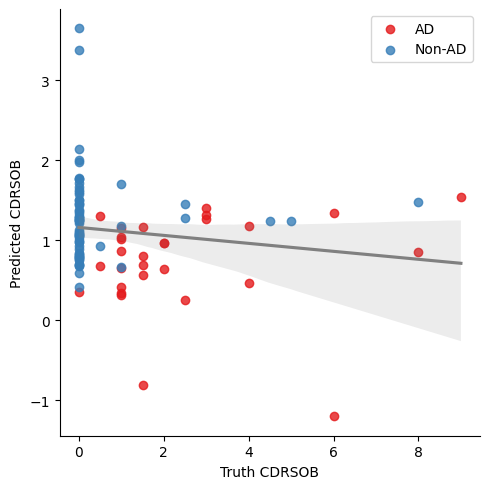

In [36]:
if flag_MMSE or flag_MMSE_Scaled: TITLE = "MMSE"
elif flag_CDR or flag_CDR_Scaled: TITLE = "CDR"
elif flag_CDRSOB or flag_CDRSOB_Scaled: TITLE = "CDRSOB"

result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth '+TITLE] = result_ground_truth
result_df['Predicted '+TITLE] = result_prediction

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth '+TITLE], result_df['Predicted '+TITLE])

hue_order = ['AD', 'Non-AD']
sns.lmplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
# if flag_MMSE or flag_MMSE_Scaled:
#     ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
#     ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
# if flag_CDR or flag_CDR_Scaled:
#     ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
#     ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
# if flag_CDRSOB or flag_CDRSOB_Scaled:
#     ax.set_xticks([0, 2, 4, 6, 8])
#     ax.set_yticks([0, 2, 4, 6, 8])  
ax.legend()

# Write to CSV file

In [37]:
score_facial_of_each_pid_sorted = {}

keys = list(score_facial_of_each_pid.keys())
keys.sort()
score_facial_of_each_pid_sorted = {i: score_facial_of_each_pid[i] for i in keys}

score_facial_of_each_pid_sorted[1]

{'Label': 0, 'Prediction': 1.608443, 'Ground_Truth': 0.0}

In [38]:
def write_result_to_csv(data_dict, fileName):
    result_list = []
    for key in data_dict:
        pid = key
        prediction = data_dict[key]['Prediction']
        label = data_dict[key]['Label']
        ground_truth = data_dict[key]['Ground_Truth']
        result_list.append([pid, prediction, label, ground_truth])
        
    field_name = ['Pid', 'Prediction', 'Label', 'Ground_Truth']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)


if flag_PreTrained==False:
    if flag_MMSE: filename = "Results/Facial_MMSE.csv"
    if flag_MMSE_Scaled: filename = "Results/Facial_MMSE_Scaled.csv"
    if flag_CDR: filename = "Results/Facial_CDR.csv"
    if flag_CDR_Scaled: filename = "Results/Facial_CDR_Scaled.csv"
    if flag_CDRSOB: filename = "Results/Facial_CDRSOB.csv"
    if flag_CDRSOB_Scaled: filename = "Results/Facial_CDRSOB_Scaled.csv"
elif flag_PreTrained==True:
    if flag_MMSE: filename = "Results/Facial_PreTrained_MMSE.csv"
    if flag_MMSE_Scaled: filename = "Results/Facial_PreTrained_MMSE_Scaled.csv"
    if flag_CDR: filename = "Results/Facial_PreTrained_CDR.csv"
    if flag_CDR_Scaled: filename = "Results/Facial_PreTrained_CDR_Scaled.csv"
    if flag_CDRSOB: filename = "Results/Facial_PreTrained_CDRSOB.csv"
    if flag_CDRSOB_Scaled: filename = "Results/Facial_PreTrained_CDRSOB_Scaled.csv"

write_result_to_csv(score_facial_of_each_pid_sorted, filename)
score_facial_of_each_pid_sorted

{1: {'Label': 0, 'Prediction': 1.608443, 'Ground_Truth': 0.0},
 2: {'Label': 0, 'Prediction': 2.1476126, 'Ground_Truth': 0.0},
 3: {'Label': 0, 'Prediction': 1.3662274, 'Ground_Truth': 0.0},
 4: {'Label': 1, 'Prediction': 0.573208, 'Ground_Truth': 1.5},
 5: {'Label': 0, 'Prediction': 1.7083228, 'Ground_Truth': 1.0},
 6: {'Label': 0, 'Prediction': 1.0988514, 'Ground_Truth': 0.0},
 7: {'Label': 0, 'Prediction': 0.8941534, 'Ground_Truth': 0.0},
 8: {'Label': 0, 'Prediction': 1.1348687, 'Ground_Truth': 0.0},
 9: {'Label': 1, 'Prediction': -1.1998173, 'Ground_Truth': 6.0},
 10: {'Label': 1, 'Prediction': 0.3452981, 'Ground_Truth': 1.0},
 11: {'Label': 1, 'Prediction': 1.5386899, 'Ground_Truth': 9.0},
 12: {'Label': 1, 'Prediction': 0.8732096, 'Ground_Truth': 1.0},
 13: {'Label': 0, 'Prediction': 1.0975435, 'Ground_Truth': 0.0},
 14: {'Label': 0, 'Prediction': 0.78366864, 'Ground_Truth': 0.0},
 15: {'Label': 0, 'Prediction': 1.0492016, 'Ground_Truth': 0.0},
 16: {'Label': 1, 'Prediction': 1.